In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import shap
import xgboost

# Prédictions sur l'énergie utilisée

Bienvenue dans ce deuxième notebook pour le projet 4 de la formation Data Scientist.

Après avoir effectué mon analyse exploratoire, je rentre dans le vif du sujet en essayant d'effectuer des prédictions.

Comme demandé dans l'intitulé, il y aura un notebook par target.

Ce notebbok est consacré à la prédiction sur l'énergie.

## Préparation des données

J'ai déjà "préparé" à la fin de l'analyse. Mais il reste toutefois plusieurs opérations à effectuer :

- Encoder les variables qualitatives.

Il ne s'agira pas d'un "OrdinalEncoder", parce que dans tous les cas (Neighborhood, Type), il n'y a pas d'ordre particulier. Je traiterai donc cet encodage avec des OneHotEncoders.

- Transformer mon dataframe en jeu d'entrainement et jeu de test.

Il s'agit simplement de séparer les données. 


Allons-y !

In [2]:
# Commençons par récupérer nos données

data = pd.read_csv("ready.csv")
data.head()

,OSEBuildingID,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,Age,logEnergyUse,logGHG
0,1,Hotel,DOWNTOWN,12,88434,60.0,88,15.824652,5.521381
1,2,Hotel,DOWNTOWN,11,103566,61.0,19,15.974742,5.689886
2,3,Hotel,DOWNTOWN,41,956110,43.0,46,18.118725,7.644575
3,5,Hotel,DOWNTOWN,10,61320,56.0,89,15.753792,5.657494
4,8,Hotel,DOWNTOWN,18,175580,75.0,35,16.500395,6.224578


In [3]:
Y = data["logEnergyUse"].round(3) #je perds un peu d'information, mais cela me servira pour la médiane plus tard
Y

0       15.825
1       15.975
2       18.119
3       15.754
4       16.500
         ...  
1578    13.757
1579    13.868
1580    15.616
1581    13.571
1582    14.073
Name: logEnergyUse, Length: 1583, dtype: float64

In [4]:
X = data.loc[:, ["PrimaryPropertyType","Neighborhood","NumberofFloors","PropertyGFATotal","Age"]] #Sans ENERGYSTAR pour l'instant
X

,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,Age
0,Hotel,DOWNTOWN,12,88434,88
1,Hotel,DOWNTOWN,11,103566,19
2,Hotel,DOWNTOWN,41,956110,46
3,Hotel,DOWNTOWN,10,61320,89
4,Hotel,DOWNTOWN,18,175580,35
...,...,...,...,...,...
1578,Small- and Mid-Sized Office,GREATER DUWAMISH,1,12294,25
1579,Other,DOWNTOWN,1,16000,11
1580,Other,MAGNOLIA / QUEEN ANNE,1,13157,41
1581,Mixed Use Property,GREATER DUWAMISH,1,14101,26


Je commence par effectuer une séparation entre jeu d'entrainement et jeu de test.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, stratify = X["PrimaryPropertyType"])

In [6]:
X_train.shape #vérifications

(1345, 5)

In [7]:
Y_test.shape

(238,)

A présent, je veux créer un outil me permettant à la fois d'encoder mes features catégorielles, et à la fois de standardiser mes features numériques.

In [8]:
numeric_features = ["NumberofFloors","PropertyGFATotal","Age"]

categorical_features = ["PrimaryPropertyType","Neighborhood"]

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

In [9]:
X_scaled = transformer.fit_transform(X_train)
X_scaled

<1345x34 sparse matrix of type '<class 'numpy.float64'>'
	with 6725 stored elements in Compressed Sparse Row format>

In [10]:
features = transformer.get_feature_names_out()
features
#En vérité, je n'ai besoin de ceci que beaucoup plus tard, lors de l'analyse de feature importances.

array(['num__NumberofFloors', 'num__PropertyGFATotal', 'num__Age',
       'cat__PrimaryPropertyType_Distribution Center',
       'cat__PrimaryPropertyType_Hospital',
       'cat__PrimaryPropertyType_Hotel',
       'cat__PrimaryPropertyType_K-12 School',
       'cat__PrimaryPropertyType_Laboratory',
       'cat__PrimaryPropertyType_Large Office',
       'cat__PrimaryPropertyType_Medical Office',
       'cat__PrimaryPropertyType_Mixed Use Property',
       'cat__PrimaryPropertyType_Other',
       'cat__PrimaryPropertyType_Refrigerated Warehouse',
       'cat__PrimaryPropertyType_Restaurant',
       'cat__PrimaryPropertyType_Retail Store',
       'cat__PrimaryPropertyType_Self-Storage Facility',
       'cat__PrimaryPropertyType_Small- and Mid-Sized Office',
       'cat__PrimaryPropertyType_Supermarket / Grocery Store',
       'cat__PrimaryPropertyType_University',
       'cat__PrimaryPropertyType_Warehouse',
       'cat__PrimaryPropertyType_Worship Facility',
       'cat__Neighborhood_BAL

In [11]:
print(X_scaled) #Première fois que j'utilise ceci, je vérifie que j'ai obtenu ce que je souhaitais

  (0, 0)	0.32092121656719147
  (0, 1)	-0.25900905089800763
  (0, 2)	1.65819641697283
  (0, 16)	1.0
  (0, 26)	1.0
  (1, 0)	-0.00794662060071134
  (1, 1)	-0.4405873305093887
  (1, 2)	1.811277861446683
  (1, 16)	1.0
  (1, 24)	1.0
  (2, 0)	-0.33681445776861413
  (2, 1)	-0.2856684357477036
  (2, 2)	0.06614939444476078
  (2, 19)	1.0
  (2, 21)	1.0
  (3, 0)	-0.33681445776861413
  (3, 1)	-0.47614895175958477
  (3, 2)	-1.3115836058199146
  (3, 11)	1.0
  (3, 30)	1.0
  (4, 0)	-0.33681445776861413
  (4, 1)	-0.00668612360066806
  (4, 2)	0.18861455002384303
  (4, 15)	1.0
  (4, 30)	1.0
  :	:
  (1340, 0)	-0.33681445776861413
  (1340, 1)	-0.41364925781017914
  (1340, 2)	-0.8217229835035855
  (1340, 6)	1.0
  (1340, 29)	1.0
  (1341, 0)	-0.00794662060071134
  (1341, 1)	-0.17198482619140634
  (1341, 2)	0.9846380612878777
  (1341, 14)	1.0
  (1341, 24)	1.0
  (1342, 0)	-0.5012483763525656
  (1342, 1)	0.3102608352159543
  (1342, 2)	-0.14816462781863315
  (1342, 19)	1.0
  (1342, 23)	1.0
  (1343, 0)	-0.3368144577

In [12]:
X_test_scaled = transformer.fit_transform(X_test)
X_test_scaled

<238x34 sparse matrix of type '<class 'numpy.float64'>'
	with 1190 stored elements in Compressed Sparse Row format>

In [13]:
print(X_test_scaled)

  (0, 0)	0.09404230091371778
  (0, 1)	0.06795846548506752
  (0, 2)	-0.6544277712962308
  (0, 8)	1.0
  (0, 27)	1.0
  (1, 0)	-0.4835594440531163
  (1, 1)	-0.41192904273887554
  (1, 2)	-1.0554575840097458
  (1, 3)	1.0
  (1, 26)	1.0
  (2, 0)	-0.3391590078114078
  (2, 1)	-0.4341198295403312
  (2, 2)	0.055086512735372926
  (2, 9)	1.0
  (2, 25)	1.0
  (3, 0)	0.3828431733971348
  (3, 1)	-0.40995141334780594
  (3, 2)	1.6900542107212422
  (3, 16)	1.0
  (3, 24)	1.0
  (4, 0)	-0.19475857156969925
  (4, 1)	-0.31068475232148063
  (4, 2)	-1.1171544782733636
  (4, 16)	1.0
  (4, 27)	1.0
  :	:
  (233, 0)	0.2384427371554263
  (233, 1)	0.7554876648573475
  (233, 2)	-1.0554575840097458
  (233, 11)	1.0
  (233, 24)	1.0
  (234, 0)	-0.4835594440531163
  (234, 1)	-0.40995141334780594
  (234, 2)	0.4252678783170792
  (234, 11)	1.0
  (234, 26)	1.0
  (235, 0)	-0.4835594440531163
  (235, 1)	-0.26840294199127274
  (235, 2)	-0.6544277712962308
  (235, 11)	1.0
  (235, 26)	1.0
  (236, 0)	0.2384427371554263
  (236, 1)	0.23

Si j'ai bien compris ce qui m'est affiché ici, ça a fonctionné comme prévu. Youpi !

Les données sont maintenant tout à fait prêtes pour effectuer des prédictions.

## Erreur utilisée pour les prédictions

J'y reviendrai plus tard car je souhaite pousser un peu ma réflexion là-dessus.

Pour l'instant, naïvement, puisque j'ai un problème de régressions, je vais utiliser l'erreur moyenne quadratique (MSE).
Je vais tout de même calculer d'autres erreurs (RMSE, R², MAE), mais mes validations croisées prendront la MSE comme valeur à optimiser.

## Baseline

En tant que baseline, je vais utiliser un "dummy" correspondant à la moyenne.

In [14]:
dummy_clf = DummyRegressor(strategy="mean")
dummy_clf.fit(X_scaled, Y_train)

DummyRegressor()

In [15]:
Y_pred = dummy_clf.predict(X_test_scaled)
mse_baseline = mean_squared_error(Y_pred,Y_test)
mse_baseline
#Sur plusieurs essais, la MSE ici oscille entre 1.7 et 1.9

1.7885389573700143

In [16]:
rmse_baseline = mean_squared_error(Y_pred,Y_test, squared = False)
mae_baseline = mean_absolute_error(Y_pred,Y_test)
r2_baseline = r2_score(Y_pred,Y_test)

#Je crée un dataframe qui me servira plus tard, dans lequel je stocke les erreurs de mes modèles.
errors = {'Algorithm': ['Dummy Mean'],
        'Best MSE': mse_baseline,
         'RMSE' : rmse_baseline,
          'MAE' : mae_baseline,
          'r2' : r2_baseline
         }

errors = pd.DataFrame(errors)

## Régression K-NN

Essayons à présent d'utiliser un régresseur K-NN pour effectuer nos prédictions.

In [17]:
knn = KNeighborsRegressor() #k = 5 par défaut

In [18]:
knn.fit(X_scaled, Y_train) #première approche naïve

KNeighborsRegressor()

In [19]:
initial_knn_mse = mean_squared_error(knn.predict(X_test_scaled),Y_test)
initial_knn_mse

0.6938086922689078

Malgré la "naïveté" de cette première approche, on fait déjà bien mieux que précédemment.

### Recherche des paramètres optimaux

On va jouer sur les paramètres suivants :

- k, le nombre de voisins pris en compte par notre k-NN.
- la pondération de chaque poids, soit tous la même pondération, soit le plus proche pèse plus lourd.
- on testera aussi les différents algorithmes de décision, dont je ne connais pas les détails.
(Finalement, je me suis rendu compte que cela n'avait pas d'impact sur les performances, alors je l'ai retiré)
- p, correspondant au fait qu'on utilise la norme 1 ou la norme 2 en tant que distance entre "voisins".

In [20]:
params = {
        'n_neighbors' : range(1,30),
        'weights' : ['uniform','distance'],
        'p' : [1,2]
        }

In [21]:
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, params, scoring = 'neg_mean_squared_error')

In [22]:
grid.fit(X_scaled,Y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [23]:
results = pd.DataFrame(grid.cv_results_)
results.head() #Voyons voir les meilleurs paramètres retournés par GridSearchCV

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001201,0.000987,0.006143,0.001089,1,1,uniform,"{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}",-1.217264,-1.256151,-1.172059,-1.113704,-1.337763,-1.219388,0.075866,114
1,0.000593,0.000484,0.005795,0.000416,1,1,distance,"{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}",-1.217264,-1.256151,-1.172059,-1.113704,-1.337763,-1.219388,0.075866,113
2,0.000401,0.000491,0.004991,0.000011,1,2,uniform,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",-1.250701,-1.241009,-1.222365,-1.122177,-1.327915,-1.232834,0.066002,115
3,0.001017,0.000026,0.004980,0.000031,1,2,distance,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",-1.250701,-1.241009,-1.222365,-1.122177,-1.327915,-1.232834,0.066002,115
4,0.000405,0.000496,0.005998,0.000022,2,1,uniform,"{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}",-0.963388,-0.942453,-0.983423,-0.896018,-1.026442,-0.962345,0.043241,111


In [24]:
#Au temps pour moi, j'ai oublié de les trier par rang
results = results.sort_values('rank_test_score').reset_index(drop = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000795,0.000397,0.006788,0.000403,14,2,distance,"{'n_neighbors': 14, 'p': 2, 'weights': 'distan...",-0.727832,-0.755957,-0.804205,-0.748379,-0.793941,-0.766063,0.028665,1
1,0.000399,0.000489,0.006744,0.000387,15,2,distance,"{'n_neighbors': 15, 'p': 2, 'weights': 'distan...",-0.720122,-0.755978,-0.810287,-0.746145,-0.798995,-0.766305,0.033613,2
2,0.000654,0.000562,0.006566,0.000468,16,2,distance,"{'n_neighbors': 16, 'p': 2, 'weights': 'distan...",-0.713319,-0.760106,-0.809606,-0.740561,-0.810477,-0.766814,0.038298,3
3,0.000597,0.000488,0.006390,0.000485,19,2,distance,"{'n_neighbors': 19, 'p': 2, 'weights': 'distan...",-0.707788,-0.763822,-0.818240,-0.740263,-0.805190,-0.767061,0.040780,4
4,0.000611,0.000499,0.006786,0.000375,21,2,distance,"{'n_neighbors': 21, 'p': 2, 'weights': 'distan...",-0.708260,-0.759539,-0.824792,-0.743778,-0.805561,-0.768386,0.042101,5


En réalité, lorsque je relance plusieurs fois mon notebook, mon jeu d'entrainement se retrouve modifié. Et cela impacte les résultats de ma validation croisée :

- k oscille entre 10 et 13.
- p vaut toujours 2 pour les meilleurs résultats
- la pondération est le plus fréquemment au top, mais pas toujours.

Une autre conséquence est que, sur le jeu de test, mon meilleur résultat ne provient pas toujours de la première ligne du tableau ci-dessus.

In [25]:
grid.best_params_ #Pour éviter de devoir modifier mon KNN à chaque relance du train/test/split, je récupère directement les paramètres

{'n_neighbors': 14, 'p': 2, 'weights': 'distance'}

In [26]:
k = grid.best_params_['n_neighbors']
p = grid.best_params_['p']
weights = grid.best_params_['weights']

In [27]:
knn = KNeighborsRegressor(n_neighbors = k, p = p, weights = weights)

In [28]:
knn.fit(X_scaled, Y_train)

KNeighborsRegressor(n_neighbors=14, weights='distance')

In [29]:
Y_pred = knn.predict(X_test_scaled)
knn_error = mean_squared_error(Y_pred,Y_test)
knn_error

0.6092368974232218

In [30]:
#Pour rappel, on avait ceci :
initial_knn_mse

0.6938086922689078

Les MSE trouvées varient à nouveau selon mon train/test/split. (de 0.7 à 0.9 pour l'erreur initiale environ) Toutefois, je constate à chaque fois une amélioration entre 5% et 10% de la MSE entre les paramètres optimaux et les paramètres initiaux.

On a donc amélioré.

Je vais stocker cette nouvelle "meilleure erreur trouvée jusqu'ici" dans mon dataframe "errors".

In [31]:
rmse_knn = mean_squared_error(Y_pred,Y_test, squared = False)
mae_knn = mean_absolute_error(Y_pred,Y_test)
r2_knn = r2_score(Y_pred,Y_test)

#Je crée une nouvelle ligne dans le dataframe errors.
new_row = {'Algorithm': 'KNN',
        'Best MSE': knn_error,
         'RMSE' : rmse_knn,
          'MAE' : mae_knn,
          'r2' : r2_knn
         }

errors.loc[len(errors)] = new_row

## Fonction traitant un type d'algorithme entièrement

Afin de ne pas reproduire l'intégralité des lignes de code ci-dessus pour chaque algorithme (Ce que j'ai fait initialement, avant d'effectuer un gros nettoyage de ce notebook à l'aide de cette fonction...), je vais créer une fonction prenant en entrée un modèle ainsi que des paramètres (pour la validation croisée).   

Je veux que la fonction :

- me donne la MSE initiale du modèle sans aucun paramètre. (Je ne m'en sers pas à la fin, c'est de la curiosité personnelle)

- effectue une validation croisée vis à vis de la MSE avec les paramètres d'entrée, et sélectionne les meilleurs

- avec les paramètres sélectionnés, utilise un meilleur modèle, calcule sa MSE (plus tard dans le projet, j'ajoute aussi le calcul de la RMSE, de la MAE, et du R², pour voir si les classements sont les mêmes ou non).

- Fait entrer ces données dans une nouvelle ligne du dataframe "errors" créé un peu plus tôt, qui servira pour la visualisation après test de tous les modèles.

- Retourne en sortie le meilleur modèle, afin qu'il soit réutilisable (beaucoup plus loin pour le boosting)

In [32]:
def test_this_model (model, params):
    #Tout d'abord, je veux connaître ma MSE initiale, sans validation croisée.
    base = model()
    base.fit(X_scaled,Y_train)
    base_error = mean_squared_error(base.predict(X_test_scaled),Y_test)
    print("MSE de base : {:.3f}".format(base_error))
    
    #Ensuite, je veux effectuer une GridSearchCV avec les paramètres que j'ai spécifiés, et récupérer les meilleurs
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error').fit(X_scaled,Y_train)
    bestmodel = model(**grid.best_params_).fit(X_scaled, Y_train)
    
    #Maintenant, je calcule la MSE avec mon modèle optimal et je l'affiche.
    Y_pred = bestmodel.predict(X_test_scaled)
    Best_error = mean_squared_error(Y_pred,Y_test)
    print("Meilleure MSE : {:.3f}".format(Best_error))
    
    #J'aimerais aussi afficher mes meilleurs paramètres.
    print(f"Meilleurs paramètres : {grid.best_params_}" )
    
    #Enfin, je remplis mon dataframe "errors"
    rmse_model = mean_squared_error(Y_pred,Y_test, squared = False)
    mae_model = mean_absolute_error(Y_pred,Y_test)
    r2_model = r2_score(Y_pred,Y_test)

    new_row = {'Algorithm': 'à remplacer', #Je souhaite afficher des noms plus clairs que juste "model", je le ferai hors-fonction
            'Best MSE': Best_error,
             'RMSE' : rmse_model,
              'MAE' : mae_model,
              'r2' : r2_model
             }

    errors.loc[len(errors)] = new_row
    
    #Renvoie le meilleur modèle
    return(bestmodel)

On teste la fonction avec le modèle K-NN et des paramètres :

In [33]:
params = {
        'n_neighbors' : range(1,30),
        'weights' : ['uniform','distance'],
        'p' : [1,2]
        }

bestknn = test_this_model(KNeighborsRegressor, params)

MSE de base : 0.694
Meilleure MSE : 0.609
Meilleurs paramètres : {'n_neighbors': 14, 'p': 2, 'weights': 'distance'}


In [34]:
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Dummy Mean,1.788539,1.337363,1.038792,-6.297896e+28
1,KNN,0.609237,0.780536,0.587052,2.979523e-01
2,à remplacer,0.609237,0.780536,0.587052,2.979523e-01


In [35]:
#Comme j'ai relancé avec le KNN, j'ai deux fois sa ligne, je vais supprimer le doublon. 
# En revanche, super, tout fonctionne comme je le souhaitais !
errors = errors.drop(index = 2)

## Modèles linéaires

### Régression linéaire

Pourquoi pas une simple régression linéaire ? Après tout, lors de l'analyse, on a observé un très beau scatterplot entre le logGFA et nos targets. Essayons et voyons ce que cela donne.

Pas de paramètres pour une validation croisée, en revanche.



In [36]:
params = {}

linreg = test_this_model(linear_model.LinearRegression, params)

MSE de base : 0.713
Meilleure MSE : 0.713
Meilleurs paramètres : {}


Je concède volontiers que je ne m'attendais pas du tout à cela.
Il semblerait que, bien que cette régression reste assez simple, elle soit déjà plus performante que notre meilleur K-NN. (Quelques relances m'ont prouvé le contraire, mais elle reste au moins aussi performante).

Il semblerait donc qu'un modèle linéaire soit relativement adapté. Allons regarder du côté des régressions plus complexes.

### Régression ridge

In [37]:
#Pour la régression ridge, je vais jouer sur alpha et sur le solver
params = {
        'alpha' : np.logspace(-4,2,20),
        'solver' : ['svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs'],
        'positive' : [True,False],
        'fit_intercept' : [False]
        }

ridgereg = test_this_model(linear_model.Ridge, params)

MSE de base : 0.711
Meilleure MSE : 0.712
Meilleurs paramètres : {'alpha': 0.007847599703514606, 'fit_intercept': False, 'positive': False, 'solver': 'cholesky'}



800 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1011, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 712, in fit
    raise ValueError(
ValueError: solver='svd' does not support positive fitting. Please set the solver to 'auto' or 'lbfgs', or set `positive=False`

--

On a quelques erreurs dûes aux incompatibilités de paramètres, mais le plus surprenant ici, c'est que la "Meilleure MSE" est... moins bonne que l'initiale ! Et a peu près similaire dans les deux cas à la régression linéaire simple. Il semblerait que la régularisation ridge n'apporte pas grand chose.

### Lasso

Reprenons les mêmes procédés avec le lasso.

In [38]:
params = {
        'alpha' : np.logspace(-4,2,50),
        'fit_intercept' : [False],
        'max_iter' : [5000]
        }

bestlasso = test_this_model(linear_model.Lasso, params)

MSE de base : 1.789
Meilleure MSE : 0.712
Meilleurs paramètres : {'alpha': 0.00017575106248547912, 'fit_intercept': False, 'max_iter': 5000}


A nouveau, avec plusieurs relances, le lasso n'est pas très convaincant non plus. Qu'à cela ne tienne, nous ne sommes pas à court d'idées.

### Elastic net

Combinons donc le ridge et le lasso pour obtenir, normalement, la meilleure version possible de notre régression linéaire.

In [39]:
elastic = linear_model.ElasticNet(fit_intercept = False, max_iter = 50000) 

In [40]:
params = {
        'alpha' : np.logspace(-5,-3,3),
        'l1_ratio' : np.linspace(0.5,0.99,5),
        'fit_intercept' : [False],
        'max_iter' : [50000]
    }

bestlastic = test_this_model(linear_model.ElasticNet, params)

MSE de base : 1.489
Meilleure MSE : 0.712
Meilleurs paramètres : {'alpha': 0.0001, 'fit_intercept': False, 'l1_ratio': 0.99, 'max_iter': 50000}


##### Conclusion sur la régularisation

Sur 3 relances globales pour modifier mon train/test/split, la différence entre ces deux erreurs... n'est pas flagrante. Elle est même fréquemment favorable à la régression linéaire simple. La régularisation, qu'elle soit ridge, lasso, ou bien encore de type ElasticNet, n'apporte rien à mes prédictions sur ce dataset.

### SVM Linéaire

A l'origine, la SVM s'occupe de problèmes de classification. Mais on peut aussi l'utiliser pour de la régression.

Essayons.

In [41]:
# Comme j'ai plus d'individus que de features, je préfère le problème primal au dual

params = {
        'epsilon' : np.linspace(0,0.3,4),
        'C' : np.logspace(-2,3,6),
        'dual' : [False],
        'fit_intercept' : [False],
        'loss' : ['squared_epsilon_insensitive']
    }

bestlinearsvr = test_this_model(LinearSVR, params)

MSE de base : 0.740
Meilleure MSE : 0.713
Meilleurs paramètres : {'C': 100.0, 'dual': False, 'epsilon': 0.0, 'fit_intercept': False, 'loss': 'squared_epsilon_insensitive'}


C'est... Sensiblement la même erreur que pour mes régressions linéaires précédentes.

Il semblerait que, en ce qui concerne les modèles linéaires, nous soyons limités à cette performance.

## Modèles non linéaires

### SVM à noyau

Essayons de modifier notre approche, en utilisant des modèles non nécessairement linéaires.

On peut le faire, par exemple, avec une SVM à noyau.

Il y a plusieurs noyaux possibles, beaucoup d'erreurs seront affichées à cause d'incompatibilités, mais lançons nous.
Je vais tester un par un les différents noyaux possibles, car il semblerait que tout tester d'un coup plante la machine.

In [42]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr = test_this_model(SVR, params)

MSE de base : 0.435
Meilleure MSE : 0.418
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}


Pour la première fois, nous observons des progrès significatifs au niveau de la MSE. C'est très encourageant.
Essayons maintenant les autres noyaux.

In [43]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'coef0' : np.logspace(-3,-1,3),
        'kernel' : ['sigmoid']
    }

bestsigmoid = test_this_model(SVR, params)

MSE de base : 0.435
Meilleure MSE : 0.767
Meilleurs paramètres : {'C': 100.0, 'coef0': 0.001, 'epsilon': 0.15, 'gamma': 0.001, 'kernel': 'sigmoid'}


On ne va définitivement pas conserver ce noyau. On pouvait s'en douter, puisque l'analyse des données ne nous a pas vraiment fait penser à une sinusoïde.
Ici, l'erreur "de base" est moins grande que l'erreur "optimisée". C'est parce que le noyau utilisé de "base" n'est pas le sigmoïde mais le "rbf".

Essayons enfin un noyau polynômial.
(En fait, pour une raison que j'ignore, et malgré plusieurs essais différents, je ne parviens pas à faire fonctionner le noyau polynômial pour la SVR. En revanche, le noyau polynômial est accessible pour le prochain modèle, donc je m'en contenterai).

### kRR (Kernel ridge regression)

Encore une fois, plusieurs noyaux sont possibles. Commençons par le noyau polynômial.

Cette fois-ci, le noyau "de base" est "linear". Comme pour le SVR à noyau sigmoid juste avant, on ne le prendra pas trop en compte ici.

In [44]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly = test_this_model(KernelRidge, params)

MSE de base : 0.731
Meilleure MSE : 0.444
Meilleurs paramètres : {'alpha': 1000.0, 'coef0': 10.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


On obtient une MSE compétitive avec la meilleure trouvée jusqu'ici (avec la première SVR à noyau), dépendamment des relances du notebook, elle est parfois meilleure, parfois moins bonne.

In [45]:
# test noyau rbf

params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf = test_this_model(KernelRidge, params)

MSE de base : 0.731
Meilleure MSE : 0.414
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


C'est également un modèle compétitif avec les deux précédents. On obtient des valeurs assez équivalentes avec les différentes relances.

### Forêt aléatoire

Puisque dans les cours proposés, j'ai également pu voir cette méthode, essayons de prédire avec des arbres de décision et du bagging.



In [46]:
params = {'n_estimators' : [100, 500, 1000], #Il est très long d'en tester plus. Je l'ai fait, et les résultats ne changent pas. Je vous l'épargne donc.
         'n_jobs' : [-1]} 

bestforest = test_this_model(RandomForestRegressor, params) #Le modèle "de base" est avec n_estimators = 100

MSE de base : 0.445
Meilleure MSE : 0.451
Meilleurs paramètres : {'n_estimators': 500, 'n_jobs': -1}


En vérité, on constate très peu de différence en terme de MSE au-delà de n_estimators = 100. En terme de temps d'entraînement il est bien meilleur, il est donc largement satisfaisant.

On constate, en terme de performance, que la forêt aléatoire fait presque aussi bien que nos meilleurs modèles jusqu'ici. pas aussi bien, mais beaucoup mieux que les modèles linéaires par exemple. 

##### Petit aparté

On constate fréquemment, et alors que ça ne devrait pas du tout avoir lieu, des meilleures performances pour les MSE "de base" que pour les "meilleures". En fait, c'est à cause de la variance de mon train/test/split original, et aussi d'un certain overfitting. En relançant le notebook, on trouve parfois des "MSE de base" un peu meilleures que les "meilleures", mais aussi parfois BEAUCOUP moins bonnes. En moyenne, et c'est plutôt rassurant, les "Meilleures" MSE sont réellement meilleures.

### Boosting

En fait, j'aimerais tester plusieurs choses : un régresseur à gradient qui part de rien, et un qui part de mon meilleur résultat actuel, pour voir s'il l'améliore ou non.

In [47]:
params = {
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

bestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 0.393
Meilleure MSE : 0.389
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 1000}


Maintenant, que se passe-t-il si je l'initialise avec mes "meilleurs" résultats ?

In [48]:
params = {
    'init' : [bestkrrpoly, bestkrrrbf, bestrbfsvr], #Ces trois là sont toujours les meilleurs et assez proches
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

realbestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 0.392
Meilleure MSE : 0.374
Meilleurs paramètres : {'init': SVR(C=100.0, epsilon=0.05, gamma=0.01), 'learning_rate': 0.01, 'n_estimators': 500}


Ce n'est pas toujours le cas, mais la plupart du temps, la MSE affichée ici est la meilleure de toutes. Le boosting me permet ici de retirer entre 2 et 4% à ma meilleure MSE, et donc, lorsque bien initialisé, c'est lui qui me permet d'obtenir le meilleur algorithme de prédiction (sans utilisation de l'ENERGY STAR score).

### Bilan des tests des différents algorithmes

In [49]:
#On peut maintenant regarder l'ensemble de nos algorithmes et leurs meilleures performances (en terme de MSE)
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Dummy Mean,1.788539,1.337363,1.038792,-6.297896e+28
1,KNN,0.609237,0.780536,0.587052,2.979523e-01
2,à remplacer,0.712533,0.844117,0.618841,2.688080e-01
3,à remplacer,0.712464,0.844076,0.618679,2.686687e-01
4,à remplacer,0.712356,0.844012,0.618384,2.681585e-01
5,à remplacer,0.712404,0.844040,0.618569,2.683906e-01
6,à remplacer,0.712505,0.844100,0.618779,2.684427e-01
7,à remplacer,0.417728,0.646318,0.483900,6.135179e-01
8,à remplacer,0.767279,0.875945,0.633944,3.309927e-01
9,à remplacer,0.443653,0.666073,0.492950,5.913145e-01


In [50]:
#Comme annoncé dans l'écriture de ma fonction test_this_model, je dois à présent renommer les "à remplacer"
errors["Algorithm"] = ["Dummy Mean", "KNN", "Basic Linear Regression", "Ridge Regression","Lasso Regression","ElasticNet","Linear SVR","rbf SVR","sigmoid SVR","polynomial KRR","rbf KRR","random forest","Gradient Boosting (Base)","Gradient Boosting from best models"]

In [51]:
#On peut maintenant trier selon les performances
errors = errors.sort_values('Best MSE').reset_index(drop = True)
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Gradient Boosting from best models,0.374208,0.611725,0.457422,7.065876e-01
1,Gradient Boosting (Base),0.388540,0.623330,0.458252,6.759440e-01
2,rbf KRR,0.414268,0.643636,0.488377,6.354776e-01
3,rbf SVR,0.417728,0.646318,0.483900,6.135179e-01
4,polynomial KRR,0.443653,0.666073,0.492950,5.913145e-01
5,random forest,0.451427,0.671883,0.499559,6.398222e-01
6,KNN,0.609237,0.780536,0.587052,2.979523e-01
7,Lasso Regression,0.712356,0.844012,0.618384,2.681585e-01
8,ElasticNet,0.712404,0.844040,0.618569,2.683906e-01
9,Ridge Regression,0.712464,0.844076,0.618679,2.686687e-01


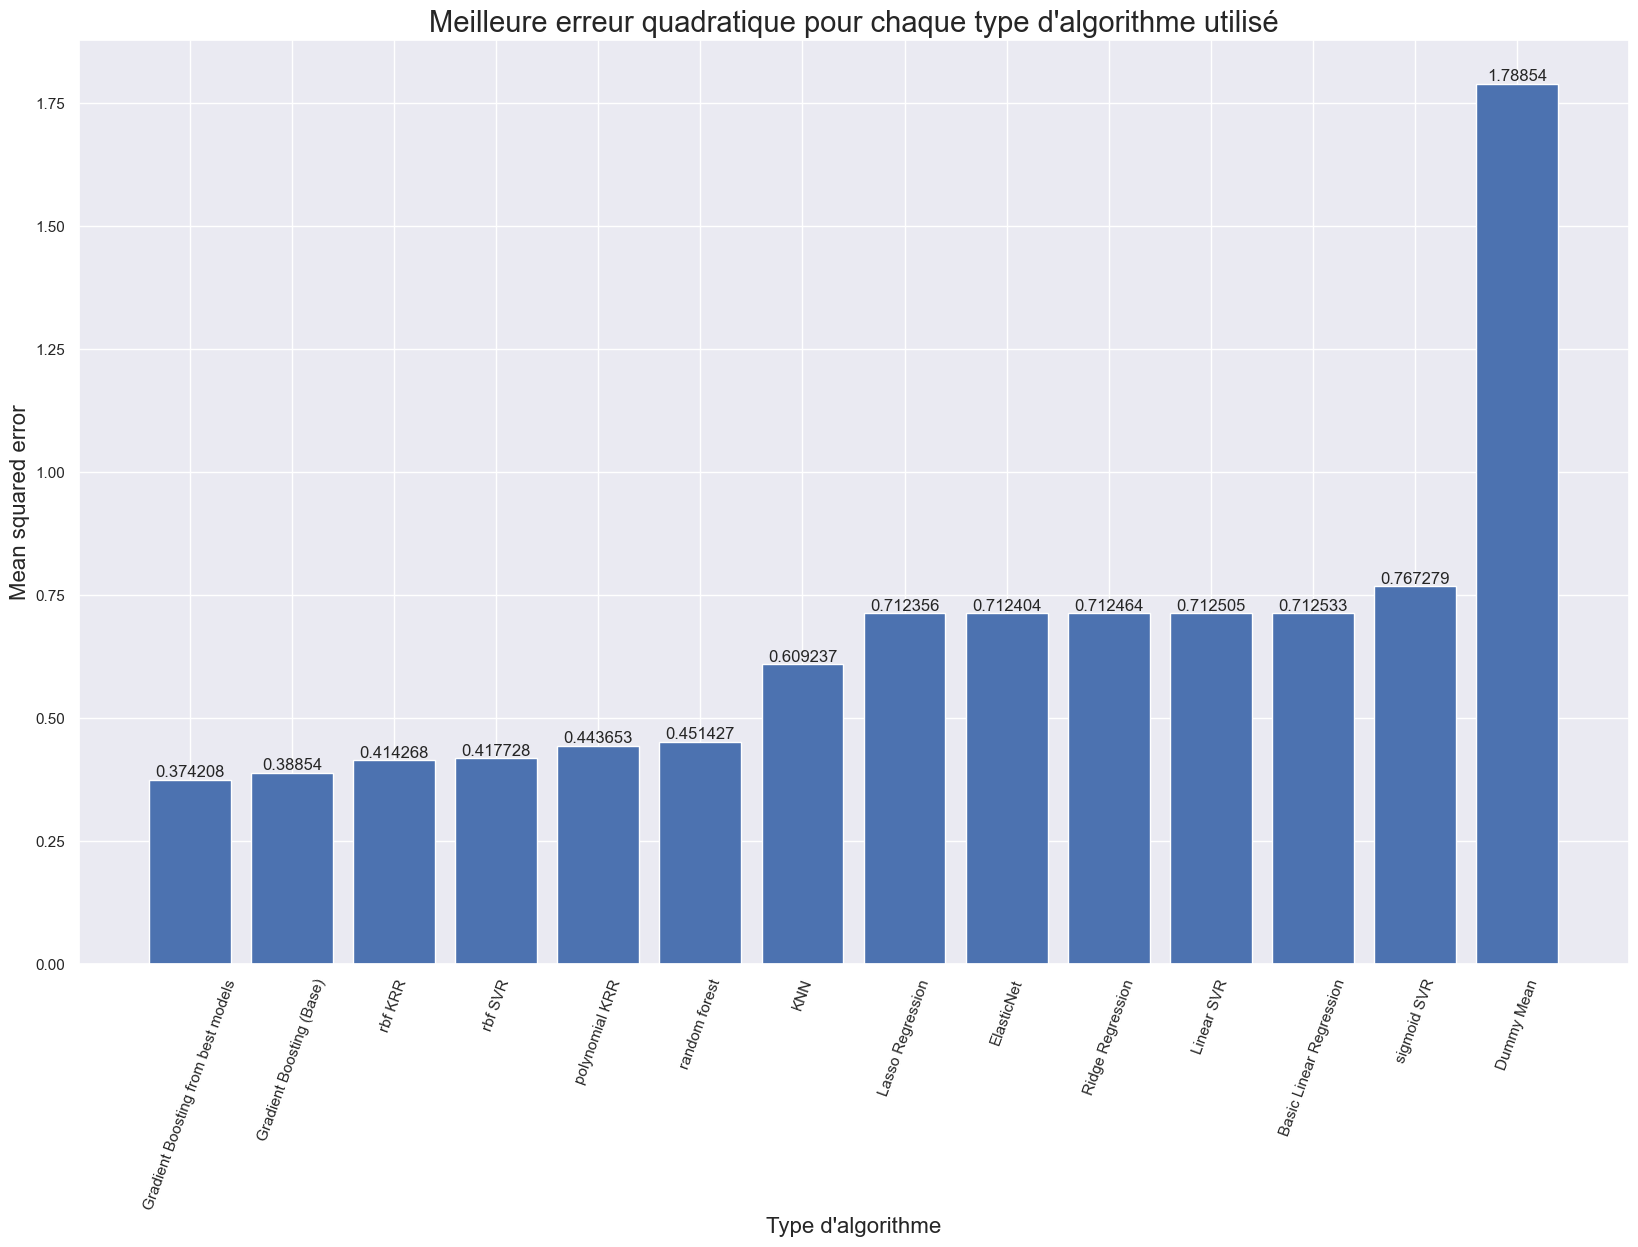

In [52]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20, 12))
bars = plt.bar(errors["Algorithm"], errors["Best MSE"])
ax.bar_label(bars)
plt.title("Meilleure erreur quadratique pour chaque type d'algorithme utilisé", fontsize = 21)
plt.xlabel("Type d'algorithme", fontsize = 16)
plt.xticks(rotation = 70)
plt.ylabel("Mean squared error", fontsize = 16)
plt.show()

## Retour sur l'erreur

J'ai fait le choix, en début de projet, de mon concentrer sur la MSE, car elle est pertinente pour les problèmes de régression, et le concept d'erreur moyenne est globalement intuitif.

J'avais hésité avec deux autres erreurs.

- La première consistait à calculer la MSE sur les valeurs *réelles* et non pas le LogEnergyUse. Donc on serait repassés à l'exponentielle avant de calculer la MSE. Pourquoi est-ce différent ? Parce qu'à ce titre, les valeurs élevées de consommation auront *beaucoup* plus d'impact sur cette erreur, puisqu'une différence d'ordre de grandeur est bien plus impactante entre 100 millions et 1 milliard (900 millions) qu'entre 10000 et 100000 (90 000). 

L'avantage, c'est que dans la globalité des mesures, on sera peut-être plus forts sur l'estimation réelle, une fois qu'on repasseà l'exponentielle pour la target.

L'inconvénient, c'est qu'on sera probablement moins forts sur les valeurs plus petites, qui auront moins eu leur mot à dire dans le calcul de l'erreur, et aussi qu'on devient très sensible aux outliers très élevés. C'est finalement pour cette raison que j'ai conservé la MSE uniquement sur la version "logarithmisée" de ma target.

- L'autre était le R², décrivant la "part" de la variance dûe à mon modèle sur la variance totale. (Plus il est proche de 1, plus le modèle décrit "bien" les valeurs réelles, plus il est proche de 0, moins mon modèle est pertinent. Par exemple, pour ma baseline, il vaut presque zéro) 

J'aurais pu choisir le R², mais j'ai préféré le côté intuitif de la MSE. Dans mon tableau "errors", on se rend compte que mon meilleur algorithme (boosté) est également le meilleur vis-à-vis du R², mais aurait-on pu faire mieux ?

Je peux tester, en modifiant légèrement la fonction "test_this_model" pour qu'elle prenne en compte le R² dans la validation croisée et non la MSE.
Notre objectif ici est d'obtenir un R² plus élevé que le meilleur qu'on ait déjà obtenu précédemment.

In [53]:
#Je créé un nouveau tableau de comparaisons
r2_test = {
    "Algorithm" : ["Best for MSE"],
    "r2" : errors.iloc[0,4] #Ceci me donne le r2 de mon meilleur algorithme pour la MSE
}

r2_test = pd.DataFrame(r2_test)

In [54]:
def test_this_model_r2 (model, params):
    #Ici, je ne me préoccupe pas d'un modèle de base, donc je supprime cette partie

    #Ensuite, je veux effectuer une GridSearchCV mais cette fois, pour le R²
    grid = GridSearchCV(model(), params, scoring = 'r2').fit(X_scaled,Y_train)
    bestmodel = model(**grid.best_params_).fit(X_scaled, Y_train)
    
    #Maintenant, je calcule le R² avec mon modèle optimal et je l'affiche.
    Y_pred = bestmodel.predict(X_test_scaled)
    Best_error = r2_score(Y_pred,Y_test)
    print("Meilleur R² : {:.3f}".format(Best_error))
    
    #J'aimerais aussi afficher mes meilleurs paramètres.
    print(f"Meilleurs paramètres : {grid.best_params_}" )
    
    #Enfin, je remplis mon dataframe "r2_test"
    new_row = {'Algorithm': 'à remplacer', #Je souhaite afficher des noms plus clairs que juste "model", je le ferai hors-fonction
              'r2' : Best_error
             }

    r2_test.loc[len(r2_test)] = new_row
    
    #Renvoie le meilleur modèle
    return(bestmodel)

Je ne vais pas tout tester, simplement les meilleurs modèles. C'est à dire les modèles à noyaux, puis le boosting appliqué dessus. Peut-être également la forêt aléatoire, pour le sport.

In [55]:
params = {'n_estimators' : [100, 500, 1000, 1500],
         'n_jobs' : [-1]} 

bestforest_r2 = test_this_model_r2(RandomForestRegressor, params) 

Meilleur R² : 0.641
Meilleurs paramètres : {'n_estimators': 1500, 'n_jobs': -1}


In [56]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr_r2 = test_this_model_r2(SVR, params)

Meilleur R² : 0.614
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}


In [57]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly_r2 = test_this_model_r2(KernelRidge, params)

Meilleur R² : 0.591
Meilleurs paramètres : {'alpha': 1000.0, 'coef0': 10.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


In [58]:
params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf_r2 = test_this_model_r2(KernelRidge, params)

Meilleur R² : 0.635
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


On se rend compte, en comparant avec la dataframe "errors", que les R² trouvés ici sont exactement les mêmes (à très peu de choses près) que ceux des meilleurs paramètres pour les MSE. Ce qui signifie que, dans notre cas ici, optimiser le r² et la MSE revient au même. (attention, je ne dis pas ça dans un cas général, simplement dans ce cas particulier)

### Une autre visualisation

Pour visualiser autrement les erreurs de notre meilleur modèle que juste un nombre (la MSE), on peut regarder un graphique comparant notre prédiction avec les valeurs réelles. Essayons cela.

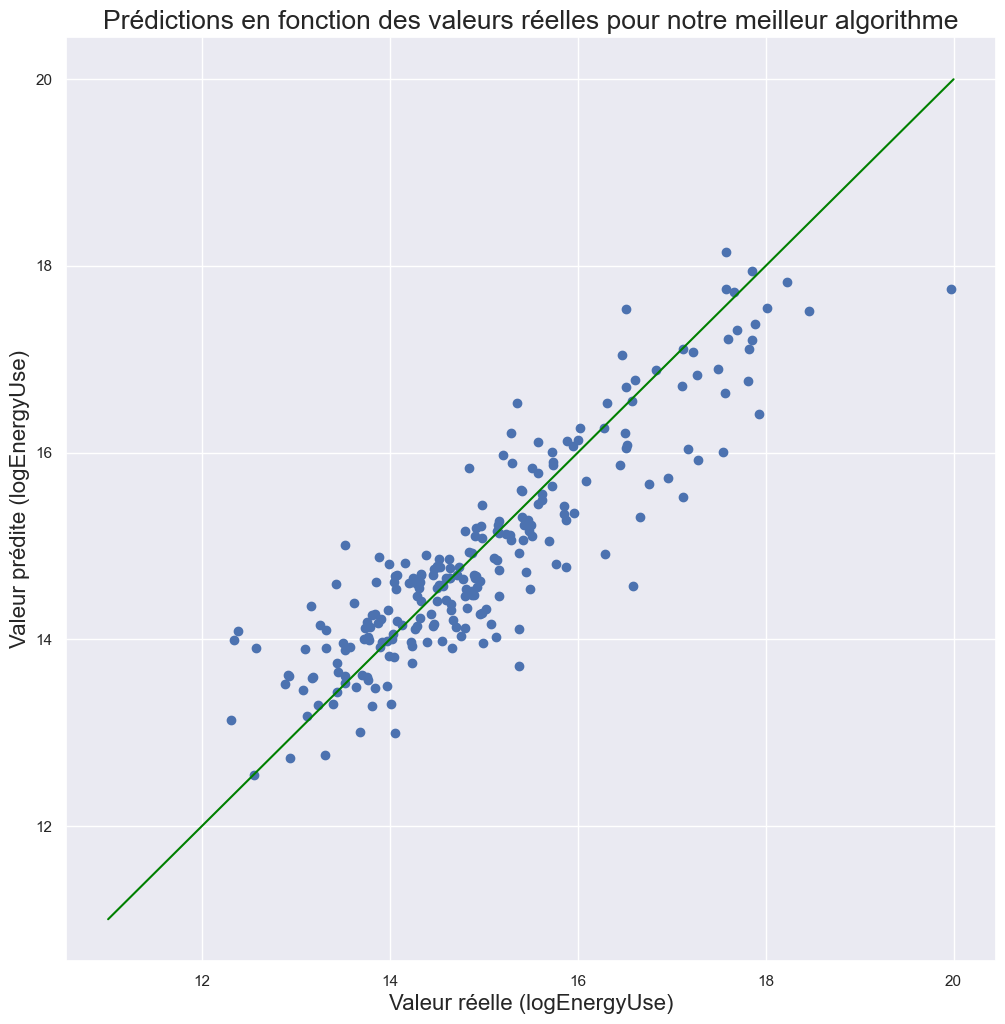

In [59]:
Y_pred = realbestgbr.predict(X_test_scaled)

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(Y_test,Y_pred)
plt.plot([11,20],[11,20],color='green') #Pour tracer l'identité, droite sur laquelle nos points seraient tous si l'algorithme était parfait
plt.title("Prédictions en fonction des valeurs réelles pour notre meilleur algorithme", fontsize = 19)
plt.xlabel("Valeur réelle (logEnergyUse)", fontsize = 16)
plt.ylabel("Valeur prédite (logEnergyUse)", fontsize = 16)
plt.show()

On constate que nos valeurs prédites ont globalement un "bon" comportement, qui suit bien la droite y = x. En revanche, on constate également qu'on a du mal à prédire correctement sur les valeurs faibles, lorsque la valeur réelle est plus basse, on est peu précis sur la prédiction (toujours au-dessus).

La bonne nouvelle, c'est qu'il y a peu ou pas de valeur prédite très loin de la valeur réelle. Notre modèle ne fait donc pas (ou peu selon les splits) de "grosses" erreurs.

#### Conclusions temporaires

- Lorsque je relance mon notebook entier (et donc le train/test/split), les résultats varient largement. Le boosting peut devenir contreproductif, le meilleur R² oscille entre 0.4 et 0.75 (peut-être même plus si je relance beaucoup), les conclusions dont je parle sur le dernier graphique (juste au-dessus) sont parfois contredites... 

Donc, selon le jeu de test qu'il me reste (seulement 238 données, c'est peu, et cela explique la variance de mes résultats), il m'est difficile de valider ou non mon modèle. 

- En revanche, en relançant plusieurs fois, je peux tout de même remarquer certaines tendances positives, notamment avec le boosting initialisé, qui me donne la plupart du temps les meilleurs résultats. L'erreur finale est "suffisamment" faible, et on aura au moins, presque à coup sûr (sauf outlier), le bon ordre de grandeur pour ma valeur ciblée (je parle d'ordre de grandeur car, rappelons-le, je prédis une valeur logarithmique ici).

### Analyse des features

Maintenant que je sais quels sont mes meilleurs modèles (et même le meilleur modèle), je souhaite savoir pour moi-même, mais aussi pour l'éventuelle présentation au client, dans un souci d'interprétabilité du modèle, quelles sont les features qui impactent le plus mes prédictions.

Pour cela, je vais utiliser SHAP (a priori, vu mon faible nombre de données, sa complexité ne devrait pas poser de problèmes).

Puisque c'est la première fois que j'utilise cette librairie, je vais l'essayer sur plusieurs modèles pertinents ici (pas les linéaires) pour "voir" plus d'exemples.

In [64]:
#Pour mon meilleur modèle, le Gradien Boosting initialisé.

explainer = shap.KernelExplainer(realbestgbr.predict, shap.sample(X_scaled,50))
shap_values = explainer.shap_values(shap.sample(X_test_scaled,50))

#Je suis obligé d'utiliser des samples, sinon ceci prend entre 7 et 8 heures (!!)

  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

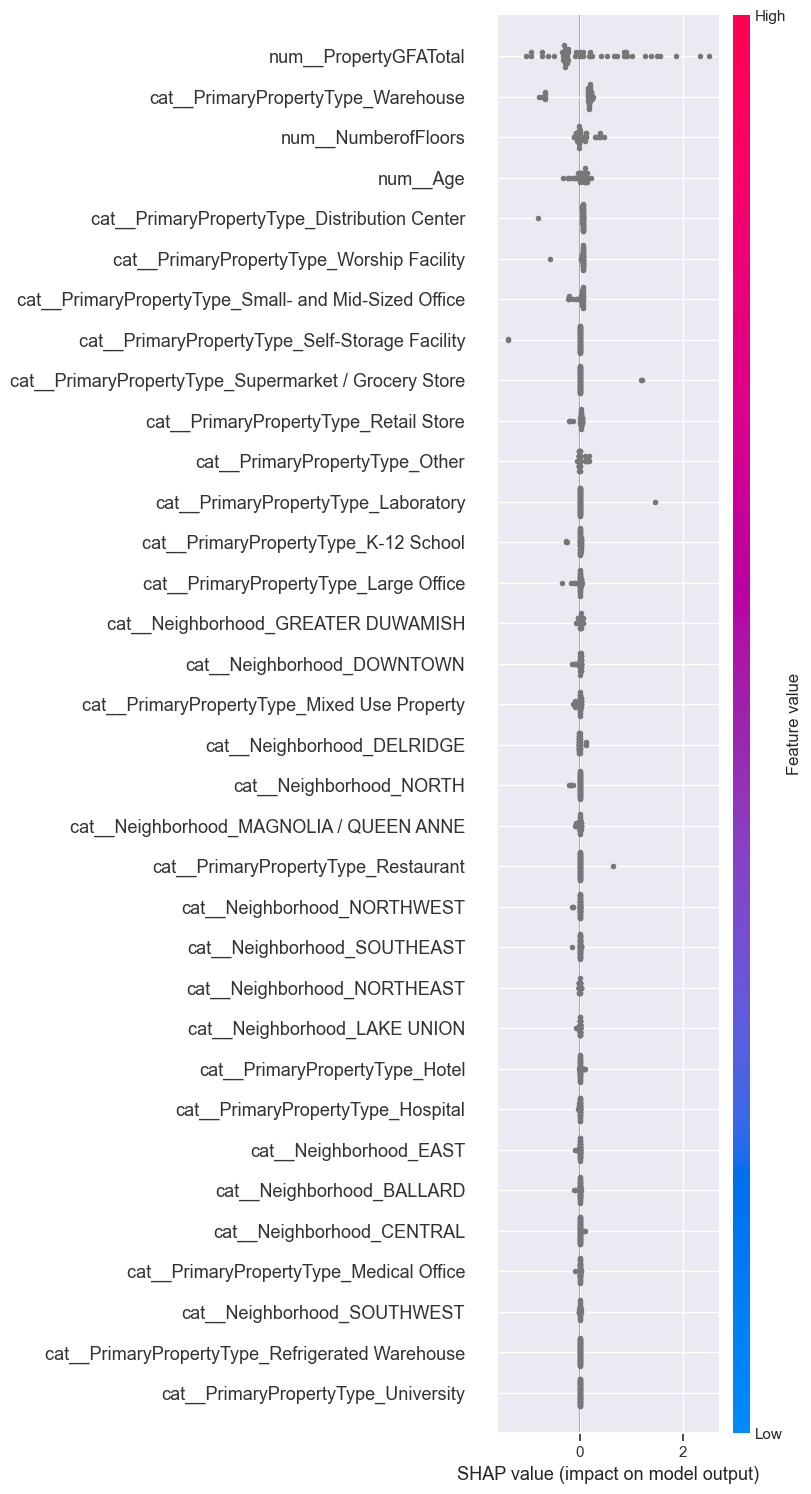

In [65]:
fig, ax = plt.subplots(figsize=(20, 12))
shap.summary_plot(shap_values,
                  feature_names = features,
                  features = X_test_scaled,
                  max_display = 34)

En fait, l'échantillonnage couplé au OneHotEncoder du départ fait qu'au final, les variables catégorielles sont mal représentées ici. Si, par exemple, on se remémore l'ANOVA sur les "PrimaryPropertyType", on devrait avoir une catégorie "Hospital" parmi les plus impactantes. Or, à cause de son faible nombre de représentants, et du sampling, ce n'est pas le cas ici.

Le problème est que, sans sampling, SHAP est bien trop long à exécuter. J'ajoute ci-dessous une ligne permettant de faire tourner SHAP sans les samples, encore une fois, pour ma machine, cela prend entre 7 et 8 heures. Je la passe donc en commentaires. Je l'ai exécutée une fois, et pris une capture d'écran, pour avoir une idée de ce que cela donne.

Using 1345 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/238 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

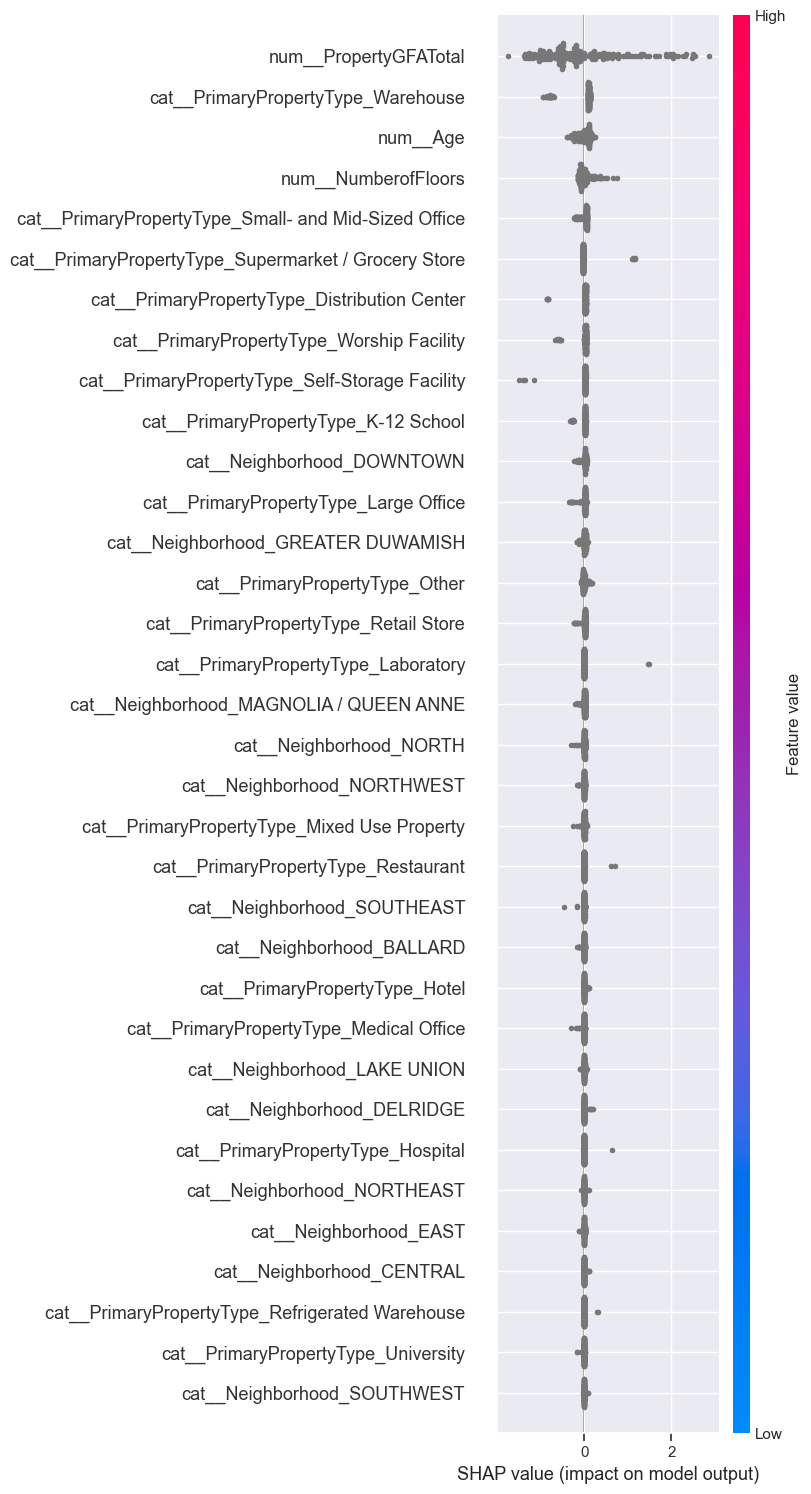

In [66]:
explainer = shap.KernelExplainer(realbestgbr.predict, X_scaled)
shap_values = explainer.shap_values(X_test_scaled)
fig, ax = plt.subplots(figsize=(20, 12))
shap.summary_plot(shap_values,
                  feature_names = features,
                  features = X_test_scaled,
                  max_display = 34)             

Dans tous les cas, la conclusion évidente qui nous apparait ici est que la feature qui pèse le plus sur nos données est, de loin, la surface du bâtiment. Viennent ensuite, dans une bien moindre mesure, l'âge et le nombre d'étages.

Certaines catégories sont assez impactantes aussi. Par exemple, les Entrepôts ne consomment pas beaucoup et, de fait, la catégorie "Entrepôt" à un impact assez important sur les prédictions. C'est pourquoi, à nouveau, la place de la catégorie "Hôpital" est erronée avec les 50 samples.

## Pertinence de la variable EnergySTARScore

### Traitement des valeurs manquantes

Pour l'Energy STAR score, il y a de nombreuses valeurs manquantes.
J'ai deux manières de procéder : imputer ou supprimer.

Or, il est en pratique complexe d'obtenir ce score, et c'est précisément pour cette raison qu'on me demande de l'évaluer. Il serait donc contreproductif d'imputer (par la moyenne par exemple) ici.

Je vais donc procéder à l'élimination des valeurs manquantes.

In [69]:
data.loc[data["ENERGYSTARScore"].isna(),:].shape

(538, 9)

In [70]:
data.shape

(1583, 9)

In [71]:
#On va perdre a peu près 1/3 des données.
data_ess = data.loc[~(data["ENERGYSTARScore"].isna()),:]

In [72]:
#On sépare les données pour isoler la target
Y = data_ess["logEnergyUse"].round(3)

X = data_ess.loc[:, ["PrimaryPropertyType","Neighborhood","NumberofFloors","PropertyGFATotal","Age","ENERGYSTARScore"]] 


#Il nous faut de nouveau un jeu d'entrainement et un jeu de test

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, stratify = X["PrimaryPropertyType"])

#On doit de nouveau scaler et encoder.

numeric_features = ["NumberofFloors","PropertyGFATotal","Age","ENERGYSTARScore"]

categorical_features = ["PrimaryPropertyType","Neighborhood"]

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

X_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.fit_transform(X_test)

features = transformer.get_feature_names_out()

A présent, je teste mes meilleurs algorithmes avec ces nouveaux datasets.

In [73]:
errors = pd.DataFrame(columns = ['Algorithm', 'Best MSE', 'RMSE','MAE','r2'])

params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr = test_this_model(SVR, params)

MSE de base : 0.353
Meilleure MSE : 0.328
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}


In [74]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly = test_this_model(KernelRidge, params)

MSE de base : 0.587
Meilleure MSE : 0.370
Meilleurs paramètres : {'alpha': 100.0, 'coef0': 10.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


In [75]:
params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf = test_this_model(KernelRidge, params)

MSE de base : 0.587
Meilleure MSE : 0.345
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


In [76]:
params = {
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

bestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 0.305
Meilleure MSE : 0.286
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 1000}


In [77]:
params = {
    'init' : [bestkrrpoly, bestkrrrbf, bestrbfsvr], #Ces trois là sont toujours les meilleurs et assez proches
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

realbestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 0.305
Meilleure MSE : 0.285
Meilleurs paramètres : {'init': SVR(C=100.0, epsilon=0.05, gamma=0.01), 'learning_rate': 0.01, 'n_estimators': 500}


In [78]:
errors["Algorithm"] = ["SVR rbf", "KernelRidgePoly","KernelRidge rbf","Gradient Boost","Initialized Gradient Boost"]

In [79]:
errors = errors.sort_values("Best MSE").reset_index(drop = True)

In [80]:
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Initialized Gradient Boost,0.284988,0.533843,0.383537,0.812080
1,Gradient Boost,0.286200,0.534976,0.380692,0.801475
2,SVR rbf,0.327963,0.572681,0.398681,0.748447
3,KernelRidge rbf,0.345430,0.587733,0.412917,0.747325
4,KernelRidgePoly,0.369624,0.607968,0.424616,0.726730


#### Premiers constats

Les résultats sont impressionants. La MSE a été réduite de plus de sa moitié. Le R² a augmenté prodigieusement également.
Rien que sur ces métriques, il est clair que l'Energy STAR Score est une excellente feature pour la prédiciton.*

*Modulo ce que je dirai plus tard


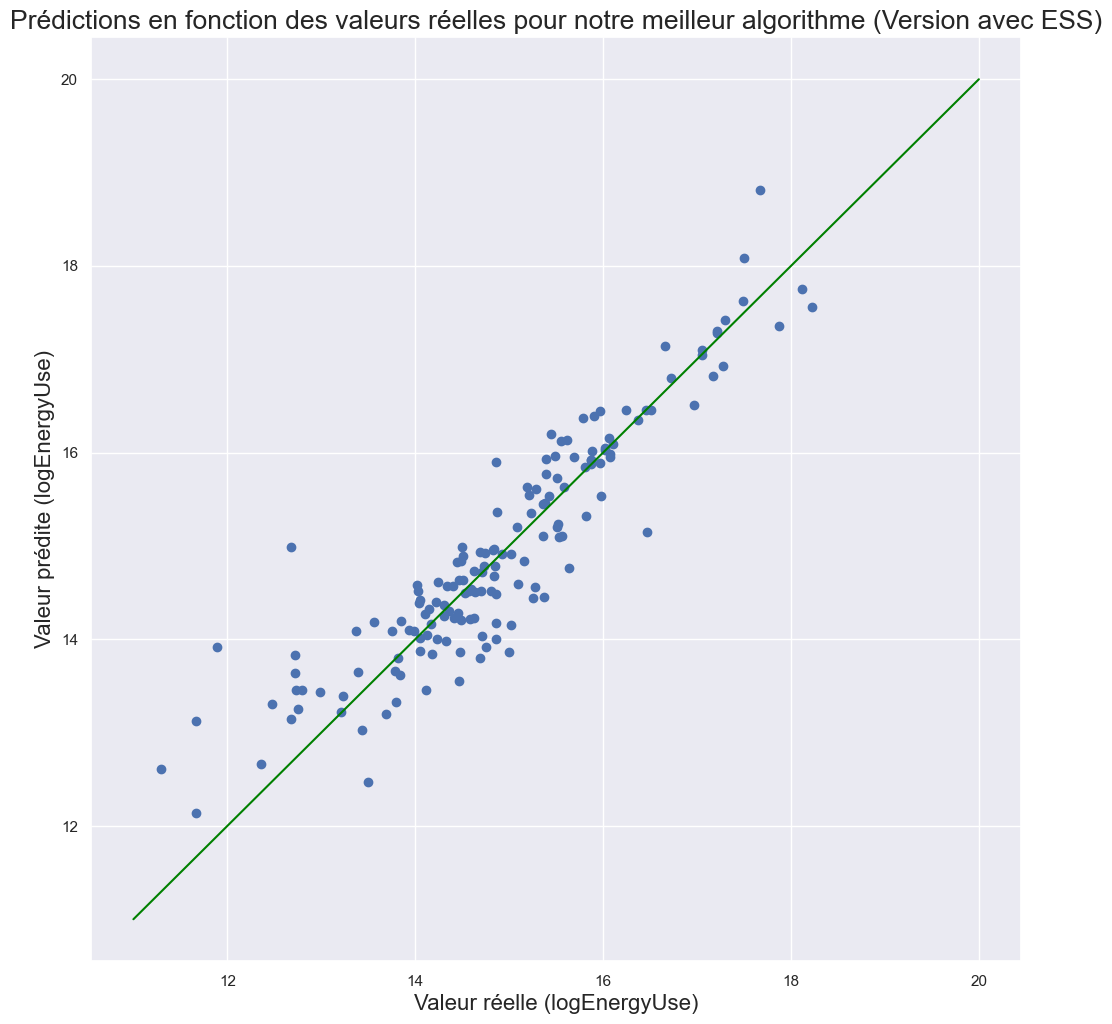

In [81]:
#On peut aussi reproduire ce graphique

Y_pred = realbestgbr.predict(X_test_scaled)

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(Y_test,Y_pred)
plt.plot([11,20],[11,20],color='green') #Pour tracer l'identité, droite sur laquelle nos points seraient tous si l'algorithme était parfait
plt.title("Prédictions en fonction des valeurs réelles pour notre meilleur algorithme (Version avec ESS)", fontsize = 19)
plt.xlabel("Valeur réelle (logEnergyUse)", fontsize = 16)
plt.ylabel("Valeur prédite (logEnergyUse)", fontsize = 16)
plt.show()

On constate également sur ce graphique que l'ensemble de nos points est très proche de l'identité ici. Cela signifie que nos prédictions sont assez précises (logarithmiquement).

#### Feature importance

A présent, je souhaite réaliser quelques analyses de feature importance avec shap, et commenter les différences avec les modèles sans ESS. l'ESS passe-t-il directement premier ? Observons.

  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

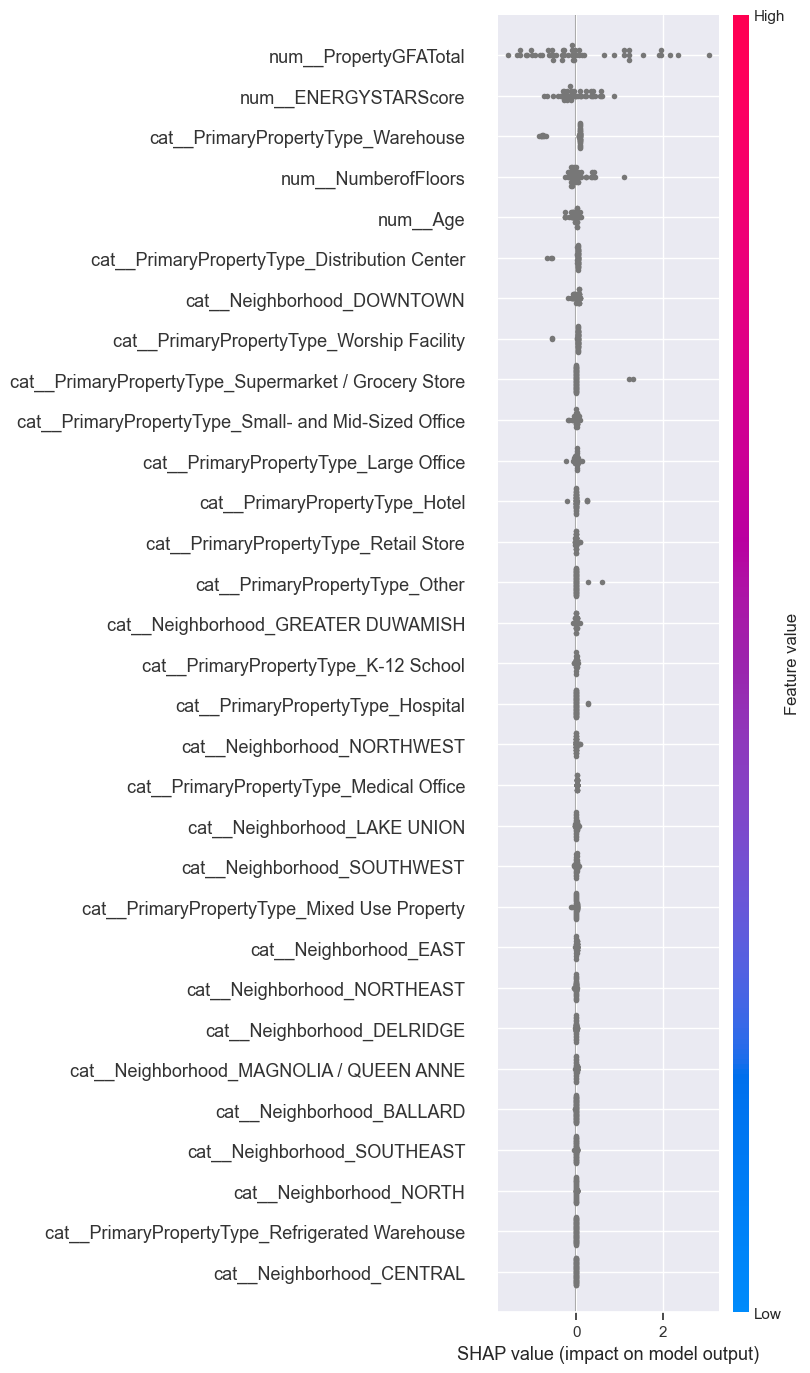

In [82]:
explainer = shap.KernelExplainer(realbestgbr.predict, shap.sample(X_scaled,50))
shap_values = explainer.shap_values(shap.sample(X_test_scaled,50))

fig, ax = plt.subplots(figsize=(20, 12))
shap.summary_plot(shap_values,
                  feature_names = features,
                  features = X_test_scaled,
                  max_display = 35)

Using 888 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/157 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

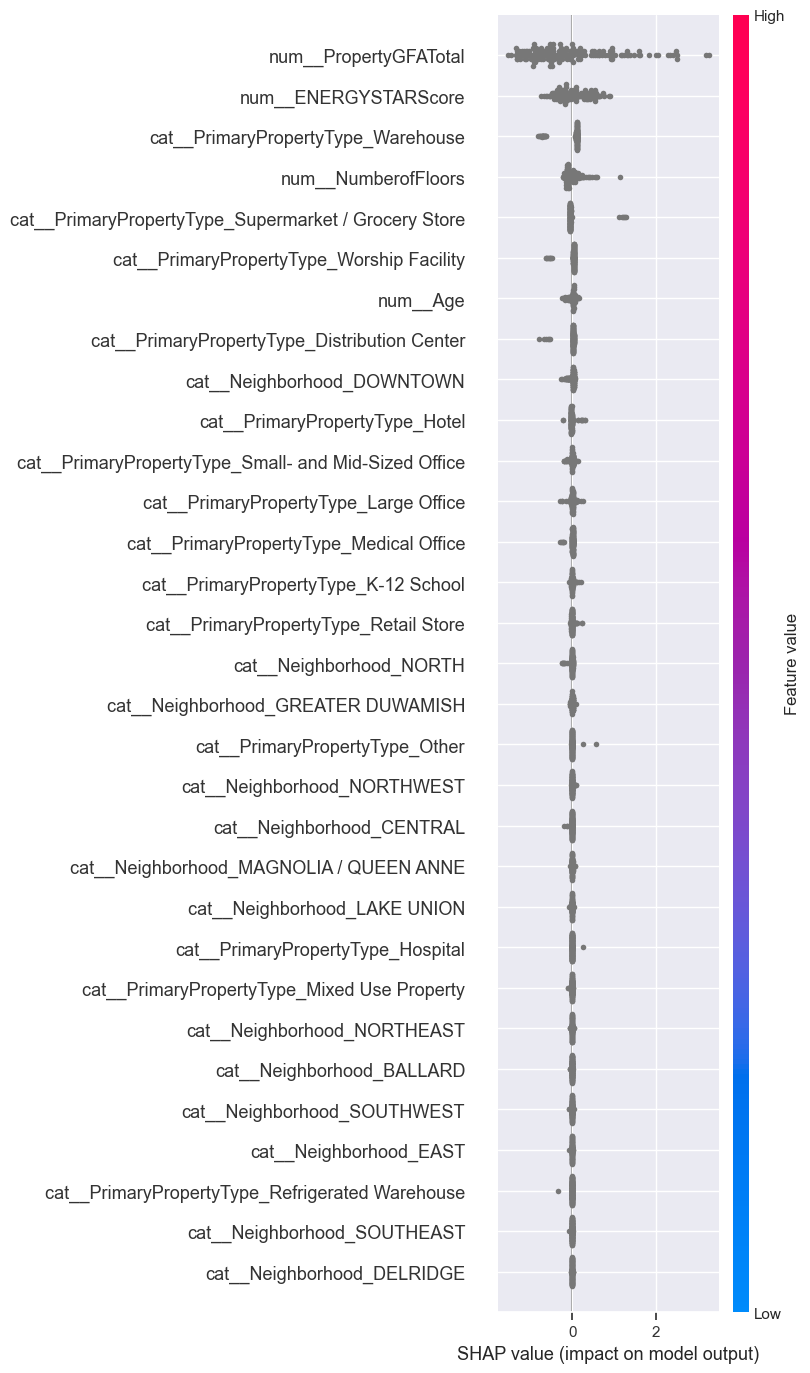

In [83]:
explainer = shap.KernelExplainer(realbestgbr.predict, X_scaled)
shap_values = explainer.shap_values(X_test_scaled)

fig, ax = plt.subplots(figsize=(20, 12))
shap.summary_plot(shap_values,
                  feature_names = features,
                  features = X_test_scaled,
                  max_display = 35)

On se rend compte, de manière peu surprenante au vu de l'impact sur l'erreur, que la feature "EnergyStarScore" est également très importante, presque à la hauteur de la surface.

## Conclusions sur l'ESS (Energy Star score)

- L'ESS nous permet très clairement d'améliorer de manière considérable la précision de nos prédictions. Il permet en outre, d'améliorer l'interprétabilité des résultats (encore que, c'est discutable puisque l'ESS lui-même est difficilement interprétable). Si je ne regardais pas le mode de calcul de l'ESS, je m'arrêterais là, et je validerais instantanément son utilisation pour les prédictions.

- Malheureusement, non seulement il est laborieux d'obtenir l'ESS, mais pour obtenir un "score énergétique", ne serait-il pas logique d'intégrer au calcul... les dépenses en énergie du bâtiment (et donc notre target) ?

Eh bien si ! Et c'est d'ailleurs naturellement le cas ici (j'ai vérifié). Et puisque la target EST utilisée dans le mode de calcul de l'ESS, alors il est impossible de prédire la target à l'aide de l'ESS... (parce que si on connait l'ESS alors cela implique nécessairement de connaitre la target au préalable).

- En conclusion, il est impossible d'utiliser l'ESS pour les prédictions, et on devra se contenter des modèles précédents.

- Je rajoute tout de même qu'on aurait pu conclure tout cela sans aucune ligne de code, et que si ça n'avait tenu qu'à moi dans un contexte professionnel, ma seule démarche aurait été de bien vérifier que l'ESS dépendait de la target, et le cas échéant j'aurais instantanément écarté l'hypothèse de son utilisation.